 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/2.%20Explore%20and%20Validate%20Data.ipynb#Validating-the-Matching" data-toc-modified-id="Validating-the-Matching-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Validating the Matching</a></span></li></ul></div>

In [1]:
%matplotlib inline

import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
import math

/Users/csutton/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
 glob.glob ('generated/matching/*')

['generated/matching/all-papers-matched-titleauthor.json',
 'generated/matching/bak',
 'generated/matching/small-papers.json',
 'generated/matching/subset__close.json',
 'generated/matching/subset__matched.json']

In [3]:
matching_file = 'generated/matching/all-papers-matched-titleauthor.json'

In [4]:
with open (matching_file) as f:
    matches = json.load (f)
    
records = [ {'area': d['area'], 'venue': d['venue'], 'year': d['year'], 'preprint': int('arxiv' in d), 'url': d.get('url', None) } for d in matches ]
df = pd.DataFrame (records)

In [5]:
venue_count = df.groupby(['venue', 'year'], as_index=False).agg({ 'preprint':
                      { 'total': 'count',
                       'matched': 'sum'
                  },
                  'area': 'first'
                })
venue_count.head()

/Users/csutton/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


venue  year preprint          area
                 total matched first
0  AAAI  2007      264       1    ai
1  AAAI  2008      251       3    ai
2  AAAI  2010      311       5    ai
3  AAAI  2011      315      12    ai
4  AAAI  2012      347      14    ai

Scan the unique list of venues to ensure the list has a reasonable length and does not include venues that are obviously duplicates. e.g., DBLP has different volumes of some conferences under separate booktiles and so forth.

In [6]:
venues = df["venue"].unique()
venues

array(['ISMB', 'IEEE VIS + VR', 'SIGGRAPH (+Asia)', 'PVLDB', 'ACL', 'RSS',
       'ICRA', 'SC', 'MobiSys', 'CCS', 'SIGMETRICS', 'SIGMOD', 'POPL',
       'USENIX', 'RECOMB', 'NSDI', 'SOSP/OSDI', 'UbiComp', 'MICRO',
       'INFOCOM', 'MobiCom', 'RTSS', 'SenSys', 'CAV', 'ICS', 'RTAS', 'ASE',
       'AAAI', 'WWW', 'ISCA', 'EuroSys', 'DAC', 'STOC', 'ICCAD',
       'HLT-NAACL', 'SODA', 'HPDC', 'FOCS', 'KDD', 'IEEE S&P', 'SIGIR',
       'CHI', 'USENIX Security', 'NIPS', 'ECCV', 'UIST', 'ICML',
       'EUROCRYPT', 'IMC', 'PLDI', 'IROS', 'CVPR', 'ICCV', 'SIGCOMM',
       'LICS', 'EMSOFT', 'ASPLOS', 'EMNLP', 'ICSE', 'CRYPTO', 'IJCAI',
       'FSE'], dtype=object)

In [7]:
len(venues)

62

See [tight layout guide](http://matplotlib.org/users/tight_layout_guide.html) for information about how to generate this grid of plots.

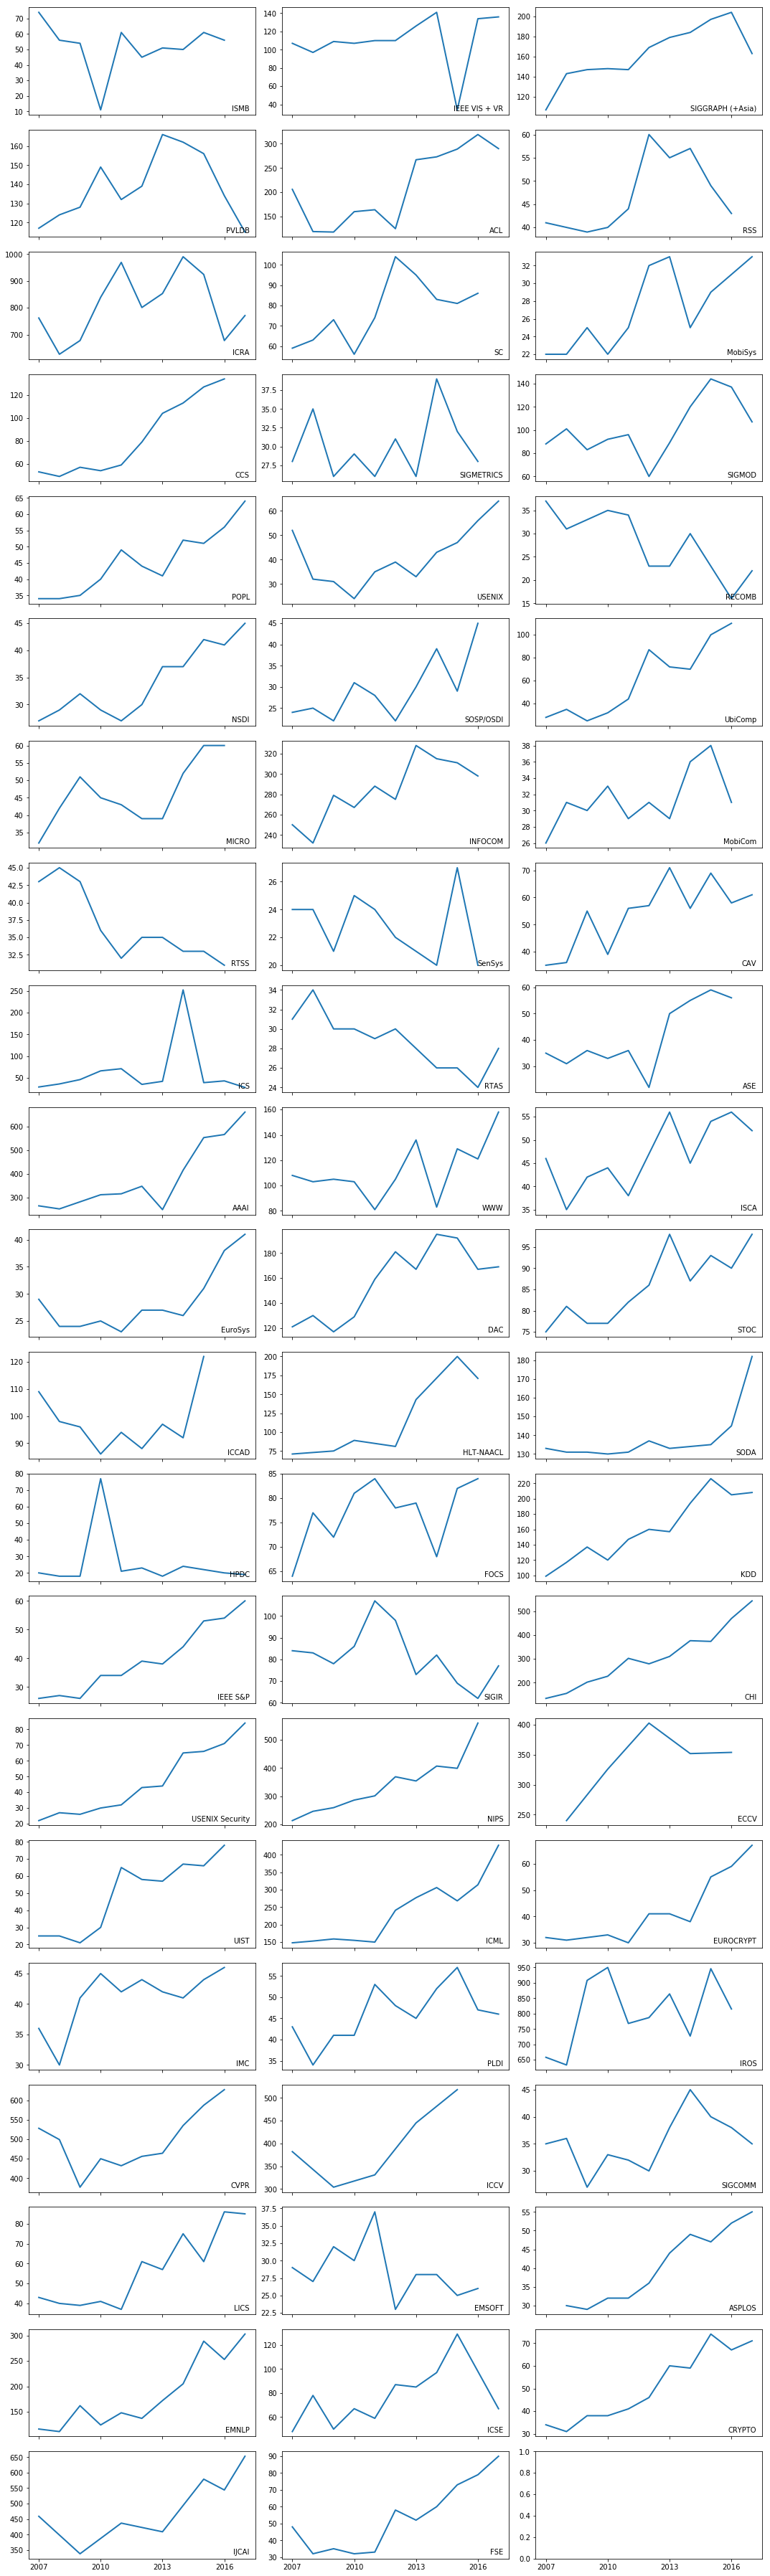

In [8]:
ncols = 3
nrows = math.ceil(len(venues) / ncols)

f, axarr = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(15, 50))
plt.xticks([2007, 2010, 2013, 2016])
plt.tight_layout()

for i in range(len(venues)):
    ri = i // ncols
    ci = i - (ncols * ri)
    df0 = venue_count[venue_count['venue'] == venues[i]]

    if (ri >= nrows): break 
        
    ax = axarr[ri,ci]
    ax.plot(df0['year'], df0['preprint', 'total'], linewidth=2.0, linestyle='-')
    ax.text(0.975, 0.025, venues[i], horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

# plt.close('all')
# plt.show()

As of 20 September 2017, it is apparent that some conferences have not yet produced proceedings for 2017. This analysis can be rerun later in the year. Perhaps I will even remember to update this text when I do so.

Note that there seem to be years missing from ISMB and IEEE VIS + VR. These are conferences whose proceedings are published in journal special issues, so it seems that we are unable to find the appropriate special issues for those years. There isn't an entry in the CS Rankings code for those years, and I wasn't able to find one quickly online.

# Validating the Matching

One sanity check that we can do on the matching procedure is to see if any DBLP articles were matched to more than one arxiv file. Occasionally that could be acceptable, e.g., if authors have prepublished multiple arxiv papers with the same title. But if this happens often it would probably indicate a bug.

In [9]:
with open (matching_file) as f:
    matches = json.load (f)

A reminder of the total number of matched DBLP articles.

In [12]:
matched = [art for art in matches if 'arxiv' in art]
multiples = [art for art in matched if len(art['arxiv'])  > 1]

In [13]:
len(matched)

7313

And the number of multiply-matched DBLP papers is 14, a vanishinly small percentage of the matches.

In [14]:
len(multiples)

14

With a bit more work, we can list all 14 and manually inspect them.

In [15]:
def filter(d, l): return [d[elt] for elt in l]
fields = ['title', 'authors', 'year', 'url', 'arxiv']
[dict(zip(fields, filter(f, fields))) for f in multiples]

[{'arxiv': ['cs/0611105', 'cs/0703107'],
  'authors': ['Arnaud Legout',
   'Nikitas Liogkas',
   'Eddie Kohler',
   'Lixia Zhang 0001'],
  'title': 'Clustering and sharing incentives in BitTorrent systems',
  'url': 'db/conf/sigmetrics/sigmetrics2007.html#LegoutLKZ07',
  'year': 2007},
 {'arxiv': ['cs/0608044', '0810.1735'],
  'authors': ['Jay Kumar Sundararajan',
   'Muriel Médard',
   'MinJi Kim',
   'Atilla Eryilmaz',
   'Devavrat Shah',
   'Ralf Koetter'],
  'title': 'Network Coding in a Multicast Switch',
  'url': 'db/conf/infocom/infocom2007.html#SundararajanMKESK07',
  'year': 2007},
 {'arxiv': ['cs/0702015', '0803.0632'],
  'authors': ['Alexandros G. Dimakis',
   'Brighten Godfrey',
   'Martin J. Wainwright',
   'Kannan Ramchandran'],
  'title': 'Network Coding for Distributed Storage Systems',
  'url': 'db/conf/infocom/infocom2007.html#DimakisGWR07',
  'year': 2007},
 {'arxiv': ['1402.2435', '1502.00621'],
  'authors': ['Bei Yu', 'Kun Yuan', 'Jhih-Rong Gao', 'David Z. Pan'],
 

We can do the same per-venue visualization for the number of matched papers as we did for the total number of papers.

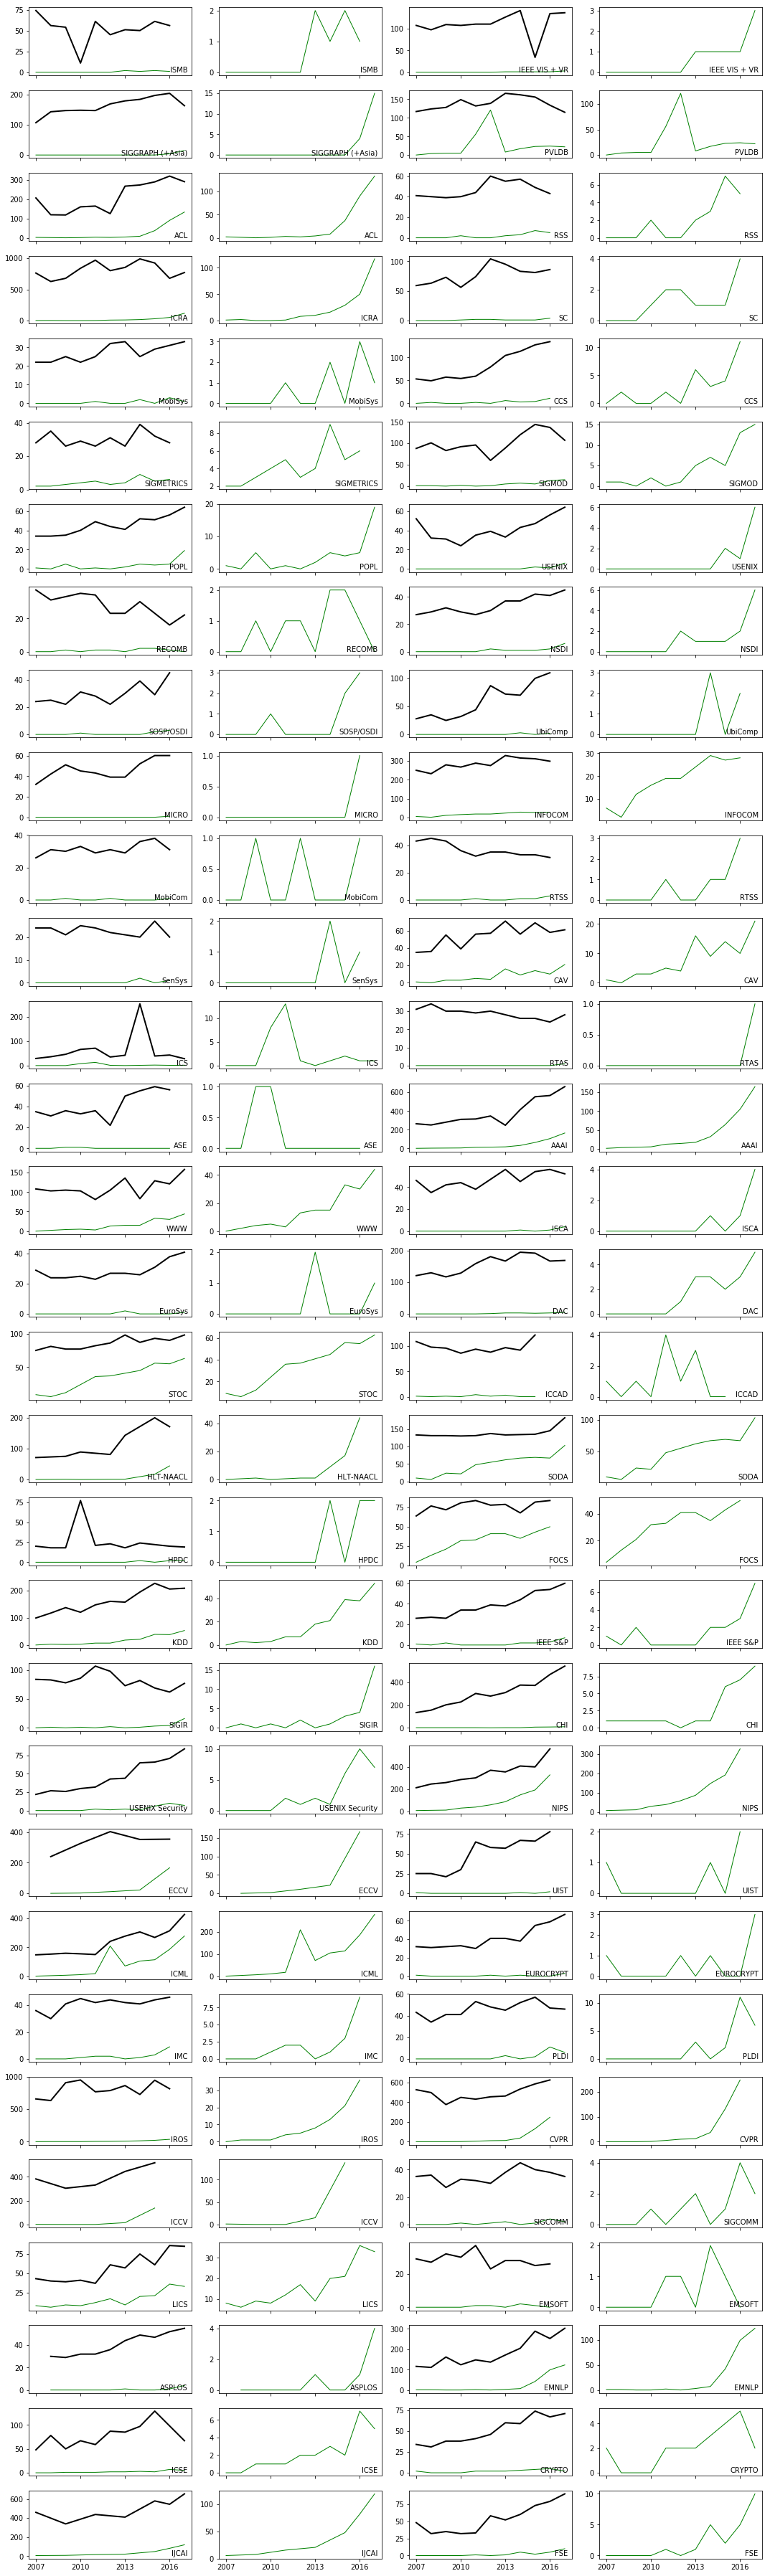

In [16]:
ncols = 2
nrows = math.ceil(len(venues) / ncols)

f, axarr = plt.subplots(nrows=nrows, ncols=2*ncols, sharex=True, sharey=False, figsize=(15, 50))
plt.xticks([2007, 2010, 2013, 2016])
plt.tight_layout()

for i in range(len(venues)):
    ri = i // ncols
    ci = 2 * (i - (ncols * ri))
    df0 = venue_count[venue_count['venue'] == venues[i]]

    if (ri >= nrows): break 
        
    ax = axarr[ri,ci]
    ax.plot(df0['year'], df0['preprint', 'total'], linewidth=2.0, color='black', linestyle='-')
    ax.plot(df0['year'], df0['preprint', 'matched'], linewidth=1.0, color='green', linestyle='-')
    ax.text(0.975, 0.025, venues[i], horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

    ax = axarr[ri,ci+1]
    ax.plot(df0['year'], df0['preprint', 'matched'], linewidth=1.0, color='green', linestyle='-')
    ax.text(0.975, 0.025, venues[i], horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

# plt.close('all')
# plt.show()

Most conference have a smooth curver in terms of the number of matched papers, except for those conferences where the per-year number of prepublished papers is very low (less than 10). The only exceptions seems to be ICML in 2012, and PVLDB in 2011.